# CIC-IDS2017 Preprocessing & 2-Stage Classification

## Overview
This notebook implements the complete preprocessing pipeline and 2-stage classification model:

**Preprocessing (Phases 1-10):**
1. Data Loading & Initial Cleanup (drop identifiers, constant, redundant features)
2. Data Cleaning (fix overflow, inf, negative values)
3. Smart Stratified Sampling (preserve rare classes)
4. Feature Selection (top 20 discriminators)
5. Feature Engineering (7 new features)
6. Target Preparation (Is_Attack + Label)
7. Train/Test Split (80/20 stratified)
8. Feature Scaling (log1p + StandardScaler)
9. SMOTE (Stage 2 rare classes only)
10. Save Artifacts

**2-Stage Model:**
- Stage 1: Binary classification (BENIGN vs ATTACK)
- Stage 2: Multi-class classification (14 attack types)

---
# Phase 0: Setup & Configuration

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import pickle
import warnings
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [2]:
# =============================================================================
# CONFIGURATION - UPDATE DATA_DIR TO YOUR PATH
# =============================================================================

DATA_DIR = "data/"  # <-- UPDATE THIS PATH
OUTPUT_DIR = "model_artifacts/"
RANDOM_STATE = 42

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Auto-discover CSV files in data directory
CSV_FILES = [f for f in os.listdir(DATA_DIR) if f.endswith('.csv')]
CSV_FILES.sort()

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Found {len(CSV_FILES)} CSV files:")
for f in CSV_FILES:
    print(f"  - {f}")

Data directory: data/
Output directory: model_artifacts/
Found 8 CSV files:
  - Benign.csv
  - Botnet.csv
  - Bruteforce.csv
  - DDoS.csv
  - DoS.csv
  - Infiltration.csv
  - Portscan.csv
  - WebAttacks.csv


In [3]:
# =============================================================================
# FEATURE LISTS FROM EDA (Pre-defined)
# =============================================================================

# Columns to drop immediately (identifiers)
IDENTIFIER_COLS = [
    'Flow ID', 'Source IP', 'Destination IP', 'Timestamp'
]

# Constant features (variance = 0)
CONSTANT_FEATURES = [
    'Bwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk',
    'Bwd PSH Flags', 'Bwd URG Flags', 'CWE Flag Count', 'ECE Flag Count',
    'Fwd Avg Bulk Rate', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk',
    'Fwd URG Flags', 'RST Flag Count'
]

# Redundant features (|correlation| > 0.95 with better feature)
REDUNDANT_FEATURES = [
    'Active Mean', 'Active Min', 'Average Packet Size', 'Avg Bwd Segment Size',
    'Avg Fwd Segment Size', 'Bwd IAT Max', 'Bwd IAT Total', 'Flow Duration',
    'Flow IAT Mean', 'Fwd IAT Mean', 'Fwd IAT Total', 'Fwd PSH Flags',
    'Fwd Packets/s', 'Idle Mean', 'Idle Min', 'Packet Length Std',
    'Subflow Bwd Bytes', 'Subflow Bwd Packets', 'Subflow Fwd Bytes',
    'Total Fwd Packets'
]

# Top 20 discriminating features (from combined score analysis)
TOP_20_FEATURES = [
    'Init_Win_bytes_backward',  # 0.945
    'Min Packet Length',        # 0.753
    'Fwd Packet Length Min',    # 0.739
    'Bwd Packet Length Std',    # 0.679
    'Fwd IAT Std',              # 0.672
    'Bwd Packet Length Min',    # 0.648
    'Fwd IAT Max',              # 0.622
    'Bwd Packets/s',            # 0.589
    'Idle Max',                 # 0.585
    'Fwd Packet Length Mean',   # 0.556
    'Fwd Packet Length Max',    # 0.535
    'PSH Flag Count',           # 0.527
    'Total Length of Fwd Packets',  # 0.517
    'Flow IAT Std',             # 0.502
    'Fwd Header Length',        # 0.452
    'Init_Win_bytes_forward',   # 0.446
    'Subflow Fwd Packets',      # 0.441
    'Flow IAT Max',             # 0.440
    'Flow Packets/s',           # 0.422
    'Bwd Packet Length Mean',   # 0.408
]

# Rare attack classes (keep 100% in sampling)
RARE_CLASSES = ['Heartbleed', 'Web Attack \x96 Sql Injection', 'Infiltration', 
                'Web Attack \x96 XSS', 'Bot']

# Alternative naming (some datasets use different encoding)
RARE_CLASSES_ALT = ['Heartbleed', 'Web Attack - Sql Injection', 'Infiltration',
                    'Web Attack - XSS', 'Bot']

# SMOTE targets for Stage 2
SMOTE_TARGETS = {
    'Heartbleed': 50,
    'Infiltration': 100,
}

print(f"Identifier columns: {len(IDENTIFIER_COLS)}")
print(f"Constant features: {len(CONSTANT_FEATURES)}")
print(f"Redundant features: {len(REDUNDANT_FEATURES)}")
print(f"Top 20 features: {len(TOP_20_FEATURES)}")

Identifier columns: 4
Constant features: 12
Redundant features: 20
Top 20 features: 20


---
# Phase 1: Data Loading & Initial Cleanup

In [4]:
%%time
# Load and combine all CSV files
print("Loading CSV files...")

dfs = []
for csv_file in CSV_FILES:
    filepath = os.path.join(DATA_DIR, csv_file)
    if os.path.exists(filepath):
        df_temp = pd.read_csv(filepath, encoding='utf-8', low_memory=False)
        # Standardize column names
        df_temp.columns = df_temp.columns.str.strip()
        dfs.append(df_temp)
        print(f"  ✓ Loaded {csv_file}: {len(df_temp):,} rows")
    else:
        print(f"  ✗ File not found: {filepath}")

# Concatenate
df = pd.concat(dfs, ignore_index=True)
print(f"\nCombined: {len(df):,} rows × {len(df.columns)} columns")

Loading CSV files...
  ✓ Loaded Benign.csv: 529,918 rows
  ✓ Loaded Botnet.csv: 191,033 rows
  ✓ Loaded Bruteforce.csv: 445,909 rows
  ✓ Loaded DDoS.csv: 225,745 rows
  ✓ Loaded DoS.csv: 692,703 rows
  ✓ Loaded Infiltration.csv: 288,602 rows
  ✓ Loaded Portscan.csv: 286,467 rows
  ✓ Loaded WebAttacks.csv: 170,366 rows

Combined: 2,830,743 rows × 84 columns
CPU times: total: 32 s
Wall time: 32.6 s


In [5]:
# Drop identifier columns
cols_before = len(df.columns)
cols_to_drop = [c for c in IDENTIFIER_COLS if c in df.columns]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
print(f"Dropped {len(cols_to_drop)} identifier columns: {cols_to_drop}")
print(f"Columns: {cols_before} → {len(df.columns)}")

Dropped 4 identifier columns: ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp']
Columns: 84 → 80


In [6]:
# Drop constant features
cols_before = len(df.columns)
cols_to_drop = [c for c in CONSTANT_FEATURES if c in df.columns]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
print(f"Dropped {len(cols_to_drop)} constant features")
print(f"Columns: {cols_before} → {len(df.columns)}")

Dropped 12 constant features
Columns: 80 → 68


In [7]:
# Drop redundant features
cols_before = len(df.columns)
cols_to_drop = [c for c in REDUNDANT_FEATURES if c in df.columns]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
print(f"Dropped {len(cols_to_drop)} redundant features")
print(f"Columns: {cols_before} → {len(df.columns)}")

Dropped 20 redundant features
Columns: 68 → 48


In [8]:
# Verify Phase 1 output
print(f"\n{'='*60}")
print(f"PHASE 1 COMPLETE")
print(f"{'='*60}")
print(f"Rows: {len(df):,}")
print(f"Columns: {len(df.columns)}")
print(f"\nRemaining columns:")
print(df.columns.tolist())


PHASE 1 COMPLETE
Rows: 2,830,743
Columns: 48

Remaining columns:
['Source Port', 'Destination Port', 'Protocol', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Min', 'Fwd Header Length', 'Bwd Header Length', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'Down/Up Ratio', 'Subflow Fwd Packets', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Std', 'Active Max', 'Idle Std', 'Idle M

---
# Phase 2: Data Cleaning

In [9]:
# Action 2.1: Remove rows with integer overflow
# Fwd/Bwd Header Length < -1e9 indicates computation error
rows_before = len(df)

overflow_mask = pd.Series(False, index=df.index)
if 'Fwd Header Length' in df.columns:
    overflow_mask |= (df['Fwd Header Length'] < -1e9)
if 'Bwd Header Length' in df.columns:
    overflow_mask |= (df['Bwd Header Length'] < -1e9)

df = df[~overflow_mask].copy()
removed = rows_before - len(df)
print(f"Removed {removed} rows with integer overflow")
print(f"Rows: {rows_before:,} → {len(df):,}")

Removed 14 rows with integer overflow
Rows: 2,830,743 → 2,830,729


In [10]:
# Action 2.2: Replace infinite values with 0
# Flow Bytes/s and Flow Packets/s can have inf due to Flow Duration = 0

for col in ['Flow Bytes/s', 'Flow Packets/s']:
    if col in df.columns:
        inf_count = np.isinf(df[col]).sum()
        if inf_count > 0:
            df[col] = df[col].replace([np.inf, -np.inf], 0)
            print(f"Replaced {inf_count} inf values in '{col}' with 0")

Replaced 1509 inf values in 'Flow Bytes/s' with 0
Replaced 2867 inf values in 'Flow Packets/s' with 0


In [11]:
# Action 2.3: Clip negative timing values to 0
# Flow IAT Min can have negative values due to timing artifacts

for col in ['Flow IAT Min']:
    if col in df.columns:
        neg_count = (df[col] < 0).sum()
        if neg_count > 0:
            df[col] = df[col].clip(lower=0)
            print(f"Clipped {neg_count} negative values in '{col}' to 0")

Clipped 2891 negative values in 'Flow IAT Min' to 0


In [12]:
# Verify Phase 2 output
print(f"\n{'='*60}")
print(f"PHASE 2 COMPLETE")
print(f"{'='*60}")
print(f"Rows: {len(df):,}")
print(f"Columns: {len(df.columns)}")

# Check for remaining issues
numeric_cols = df.select_dtypes(include=[np.number]).columns
inf_check = np.isinf(df[numeric_cols]).sum().sum()
nan_check = df[numeric_cols].isna().sum().sum()
print(f"\nRemaining inf values: {inf_check}")
print(f"Remaining NaN values: {nan_check}")


PHASE 2 COMPLETE
Rows: 2,830,729
Columns: 48

Remaining inf values: 0
Remaining NaN values: 1358


---
# Phase 3: Smart Stratified Sampling

In [13]:
# Check label distribution
print("Label distribution (before sampling):")
label_counts = df['Label'].value_counts()
print(label_counts)
print(f"\nTotal: {len(df):,} rows, {len(label_counts)} classes")

Label distribution (before sampling):
Label
BENIGN                        2273083
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

Total: 2,830,729 rows, 15 classes


In [14]:
# Identify rare classes (< 500 samples or in predefined list)
rare_threshold = 500
sample_fraction = 0.05  # 5% for common classes

# Get actual class names from data
all_classes = df['Label'].unique()
rare_classes = []

for label in all_classes:
    count = (df['Label'] == label).sum()
    if count < rare_threshold:
        rare_classes.append(label)
        
# Also include Bot if present (< 2000 samples)
for label in all_classes:
    if 'Bot' in label and label not in rare_classes:
        count = (df['Label'] == label).sum()
        if count < 2000:
            rare_classes.append(label)

print(f"Rare classes (keep 100%): {rare_classes}")
print(f"Common classes (sample {sample_fraction*100:.0f}%): {[c for c in all_classes if c not in rare_classes]}")

Rare classes (keep 100%): ['Heartbleed', 'Infiltration', 'Web Attack � Sql Injection', 'Bot']
Common classes (sample 5%): ['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DDoS', 'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'PortScan', 'Web Attack � Brute Force', 'Web Attack � XSS']


In [15]:
%%time
# Smart stratified sampling
print("\nPerforming smart stratified sampling...")

sampled_dfs = []

for label in all_classes:
    df_class = df[df['Label'] == label]
    original_count = len(df_class)
    
    if label in rare_classes:
        # Keep 100% of rare classes
        sampled_dfs.append(df_class)
        print(f"  {label}: {original_count:,} → {original_count:,} (100%)")
    else:
        # Sample common classes
        n_samples = max(int(original_count * sample_fraction), 1)
        df_sampled = df_class.sample(n=n_samples, random_state=RANDOM_STATE)
        sampled_dfs.append(df_sampled)
        print(f"  {label}: {original_count:,} → {n_samples:,} ({sample_fraction*100:.0f}%)")

# Combine sampled data
df_sampled = pd.concat(sampled_dfs, ignore_index=True)
df_sampled = df_sampled.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)  # Shuffle

print(f"\nTotal sampled: {len(df_sampled):,} rows")


Performing smart stratified sampling...
  BENIGN: 2,273,083 → 113,654 (5%)
  Bot: 1,966 → 1,966 (100%)
  FTP-Patator: 7,938 → 396 (5%)
  SSH-Patator: 5,897 → 294 (5%)
  DDoS: 128,027 → 6,401 (5%)
  DoS slowloris: 5,796 → 289 (5%)
  DoS Slowhttptest: 5,499 → 274 (5%)
  DoS Hulk: 231,073 → 11,553 (5%)
  DoS GoldenEye: 10,293 → 514 (5%)
  Heartbleed: 11 → 11 (100%)
  Infiltration: 36 → 36 (100%)
  PortScan: 158,930 → 7,946 (5%)
  Web Attack � Brute Force: 1,507 → 75 (5%)
  Web Attack � XSS: 652 → 32 (5%)
  Web Attack � Sql Injection: 21 → 21 (100%)

Total sampled: 143,462 rows
CPU times: total: 3.12 s
Wall time: 3.21 s


In [16]:
# Verify Phase 3 output
print(f"\n{'='*60}")
print(f"PHASE 3 COMPLETE")
print(f"{'='*60}")
print(f"Original rows: {len(df):,}")
print(f"Sampled rows: {len(df_sampled):,}")
print(f"Reduction: {(1 - len(df_sampled)/len(df))*100:.1f}%")
print(f"\nLabel distribution (after sampling):")
print(df_sampled['Label'].value_counts())

# Use sampled data from now on
df = df_sampled.copy()
del df_sampled


PHASE 3 COMPLETE
Original rows: 2,830,729
Sampled rows: 143,462
Reduction: 94.9%

Label distribution (after sampling):
Label
BENIGN                        113654
DoS Hulk                       11553
PortScan                        7946
DDoS                            6401
Bot                             1966
DoS GoldenEye                    514
FTP-Patator                      396
SSH-Patator                      294
DoS slowloris                    289
DoS Slowhttptest                 274
Web Attack � Brute Force          75
Infiltration                      36
Web Attack � XSS                  32
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64


---
# Phase 4: Feature Selection (Top 20)

In [17]:
# Check which top 20 features are present
available_top20 = [f for f in TOP_20_FEATURES if f in df.columns]
missing_top20 = [f for f in TOP_20_FEATURES if f not in df.columns]

print(f"Available top 20 features: {len(available_top20)}/{len(TOP_20_FEATURES)}")
if missing_top20:
    print(f"Missing features: {missing_top20}")

Available top 20 features: 20/20


In [18]:
# Select top 20 features + Label
keep_cols = available_top20 + ['Label']
df = df[keep_cols].copy()

print(f"\n{'='*60}")
print(f"PHASE 4 COMPLETE")
print(f"{'='*60}")
print(f"Selected {len(available_top20)} features + Label")
print(f"Columns: {df.columns.tolist()}")


PHASE 4 COMPLETE
Selected 20 features + Label
Columns: ['Init_Win_bytes_backward', 'Min Packet Length', 'Fwd Packet Length Min', 'Bwd Packet Length Std', 'Fwd IAT Std', 'Bwd Packet Length Min', 'Fwd IAT Max', 'Bwd Packets/s', 'Idle Max', 'Fwd Packet Length Mean', 'Fwd Packet Length Max', 'PSH Flag Count', 'Total Length of Fwd Packets', 'Flow IAT Std', 'Fwd Header Length', 'Init_Win_bytes_forward', 'Subflow Fwd Packets', 'Flow IAT Max', 'Flow Packets/s', 'Bwd Packet Length Mean', 'Label']


---
# Phase 5: Feature Engineering

In [19]:
# Action 5.1: Create binary indicator features

# has_tcp_handshake: Init_Win_bytes_backward != -1 means TCP handshake was observed
if 'Init_Win_bytes_backward' in df.columns:
    df['has_tcp_handshake'] = (df['Init_Win_bytes_backward'] != -1).astype(int)
    print(f"Created 'has_tcp_handshake': {df['has_tcp_handshake'].mean()*100:.1f}% True")

# is_zero_window: Init_Win_bytes_backward == 0
if 'Init_Win_bytes_backward' in df.columns:
    df['is_zero_window'] = (df['Init_Win_bytes_backward'] == 0).astype(int)
    print(f"Created 'is_zero_window': {df['is_zero_window'].mean()*100:.1f}% True")

# is_zero_duration: Flow IAT Max == 0 (single-packet flow)
if 'Flow IAT Max' in df.columns:
    df['is_zero_duration'] = (df['Flow IAT Max'] == 0).astype(int)
    print(f"Created 'is_zero_duration': {df['is_zero_duration'].mean()*100:.1f}% True")

Created 'has_tcp_handshake': 49.8% True
Created 'is_zero_window': 9.8% True
Created 'is_zero_duration': 0.1% True


In [20]:
# Action 5.2: Create cleaned sentinel features (clip -1 to 0)

if 'Init_Win_bytes_backward' in df.columns:
    df['init_win_bwd_clean'] = df['Init_Win_bytes_backward'].clip(lower=0)
    print(f"Created 'init_win_bwd_clean': clipped {(df['Init_Win_bytes_backward'] == -1).sum():,} sentinel values")

if 'Init_Win_bytes_forward' in df.columns:
    df['init_win_fwd_clean'] = df['Init_Win_bytes_forward'].clip(lower=0)
    print(f"Created 'init_win_fwd_clean': clipped {(df['Init_Win_bytes_forward'] == -1).sum():,} sentinel values")

Created 'init_win_bwd_clean': clipped 72,066 sentinel values
Created 'init_win_fwd_clean': clipped 50,014 sentinel values


In [21]:
# Action 5.3: Create ratio features

# fwd_bwd_packet_ratio: Forward/Backward packet ratio
if 'Subflow Fwd Packets' in df.columns and 'Bwd Packets/s' in df.columns:
    # Use Bwd Packets/s as proxy for backward packet count
    # Add 1 to avoid division by zero
    df['fwd_bwd_packet_ratio'] = df['Subflow Fwd Packets'] / (df['Bwd Packets/s'] + 1)
    print(f"Created 'fwd_bwd_packet_ratio'")

# fwd_bwd_bytes_ratio: Forward/Backward bytes ratio
if 'Total Length of Fwd Packets' in df.columns and 'Bwd Packet Length Mean' in df.columns:
    # Use Bwd Packet Length Mean as proxy for total backward bytes
    df['fwd_bwd_bytes_ratio'] = df['Total Length of Fwd Packets'] / (df['Bwd Packet Length Mean'] + 1)
    print(f"Created 'fwd_bwd_bytes_ratio'")

Created 'fwd_bwd_packet_ratio'
Created 'fwd_bwd_bytes_ratio'


In [22]:
# Verify Phase 5 output
print(f"\n{'='*60}")
print(f"PHASE 5 COMPLETE")
print(f"{'='*60}")

feature_cols = [c for c in df.columns if c != 'Label']
print(f"Total features: {len(feature_cols)}")
print(f"\nFeatures:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2}. {col}")


PHASE 5 COMPLETE
Total features: 27

Features:
   1. Init_Win_bytes_backward
   2. Min Packet Length
   3. Fwd Packet Length Min
   4. Bwd Packet Length Std
   5. Fwd IAT Std
   6. Bwd Packet Length Min
   7. Fwd IAT Max
   8. Bwd Packets/s
   9. Idle Max
  10. Fwd Packet Length Mean
  11. Fwd Packet Length Max
  12. PSH Flag Count
  13. Total Length of Fwd Packets
  14. Flow IAT Std
  15. Fwd Header Length
  16. Init_Win_bytes_forward
  17. Subflow Fwd Packets
  18. Flow IAT Max
  19. Flow Packets/s
  20. Bwd Packet Length Mean
  21. has_tcp_handshake
  22. is_zero_window
  23. is_zero_duration
  24. init_win_bwd_clean
  25. init_win_fwd_clean
  26. fwd_bwd_packet_ratio
  27. fwd_bwd_bytes_ratio


---
# Phase 6: Target Preparation

In [23]:
# Create binary target for Stage 1
df['Is_Attack'] = (df['Label'] != 'BENIGN').astype(int)

print("Binary target distribution:")
print(df['Is_Attack'].value_counts())
print(f"\nBENIGN: {(df['Is_Attack']==0).sum():,}")
print(f"ATTACK: {(df['Is_Attack']==1).sum():,}")
print(f"Ratio (attack/benign): {(df['Is_Attack']==1).sum() / (df['Is_Attack']==0).sum():.2f}")

Binary target distribution:
Is_Attack
0    113654
1     29808
Name: count, dtype: int64

BENIGN: 113,654
ATTACK: 29,808
Ratio (attack/benign): 0.26


In [24]:
# Encode multi-class labels for Stage 2
label_encoder = LabelEncoder()
df['Label_Encoded'] = label_encoder.fit_transform(df['Label'])

print("Multi-class label encoding:")
for i, label in enumerate(label_encoder.classes_):
    count = (df['Label'] == label).sum()
    print(f"  {i:2}: {label} ({count:,})")

# Save label encoder
with open(os.path.join(OUTPUT_DIR, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"\nSaved label encoder to {OUTPUT_DIR}label_encoder.pkl")

Multi-class label encoding:
   0: BENIGN (113,654)
   1: Bot (1,966)
   2: DDoS (6,401)
   3: DoS GoldenEye (514)
   4: DoS Hulk (11,553)
   5: DoS Slowhttptest (274)
   6: DoS slowloris (289)
   7: FTP-Patator (396)
   8: Heartbleed (11)
   9: Infiltration (36)
  10: PortScan (7,946)
  11: SSH-Patator (294)
  12: Web Attack � Brute Force (75)
  13: Web Attack � Sql Injection (21)
  14: Web Attack � XSS (32)

Saved label encoder to model_artifacts/label_encoder.pkl


In [25]:
print(f"\n{'='*60}")
print(f"PHASE 6 COMPLETE")
print(f"{'='*60}")
print(f"Columns: {df.columns.tolist()}")


PHASE 6 COMPLETE
Columns: ['Init_Win_bytes_backward', 'Min Packet Length', 'Fwd Packet Length Min', 'Bwd Packet Length Std', 'Fwd IAT Std', 'Bwd Packet Length Min', 'Fwd IAT Max', 'Bwd Packets/s', 'Idle Max', 'Fwd Packet Length Mean', 'Fwd Packet Length Max', 'PSH Flag Count', 'Total Length of Fwd Packets', 'Flow IAT Std', 'Fwd Header Length', 'Init_Win_bytes_forward', 'Subflow Fwd Packets', 'Flow IAT Max', 'Flow Packets/s', 'Bwd Packet Length Mean', 'Label', 'has_tcp_handshake', 'is_zero_window', 'is_zero_duration', 'init_win_bwd_clean', 'init_win_fwd_clean', 'fwd_bwd_packet_ratio', 'fwd_bwd_bytes_ratio', 'Is_Attack', 'Label_Encoded']


---
# Phase 7: Train/Test Split

In [26]:
# Define feature columns
feature_cols = [c for c in df.columns if c not in ['Label', 'Is_Attack', 'Label_Encoded']]
print(f"Feature columns ({len(feature_cols)}): {feature_cols}")

Feature columns (27): ['Init_Win_bytes_backward', 'Min Packet Length', 'Fwd Packet Length Min', 'Bwd Packet Length Std', 'Fwd IAT Std', 'Bwd Packet Length Min', 'Fwd IAT Max', 'Bwd Packets/s', 'Idle Max', 'Fwd Packet Length Mean', 'Fwd Packet Length Max', 'PSH Flag Count', 'Total Length of Fwd Packets', 'Flow IAT Std', 'Fwd Header Length', 'Init_Win_bytes_forward', 'Subflow Fwd Packets', 'Flow IAT Max', 'Flow Packets/s', 'Bwd Packet Length Mean', 'has_tcp_handshake', 'is_zero_window', 'is_zero_duration', 'init_win_bwd_clean', 'init_win_fwd_clean', 'fwd_bwd_packet_ratio', 'fwd_bwd_bytes_ratio']


In [27]:
# Prepare X and y
X = df[feature_cols]
y_binary = df['Is_Attack']           # For Stage 1
y_multiclass = df['Label_Encoded']    # For Stage 2
y_label = df['Label']                 # Original labels for reference

print(f"X shape: {X.shape}")
print(f"y_binary shape: {y_binary.shape}")
print(f"y_multiclass shape: {y_multiclass.shape}")

X shape: (143462, 27)
y_binary shape: (143462,)
y_multiclass shape: (143462,)


In [28]:
# Stratified train/test split (stratify by Label to preserve all classes)
X_train, X_test, y_train_binary, y_test_binary, y_train_multi, y_test_multi, y_train_label, y_test_label = train_test_split(
    X, y_binary, y_multiclass, y_label,
    test_size=0.20,
    stratify=y_label,
    random_state=RANDOM_STATE
)

print(f"Train set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

Train set: 114,769 samples (80.0%)
Test set: 28,693 samples (20.0%)


In [29]:
# Verify stratification
print("\nTrain set label distribution:")
print(y_train_label.value_counts())

print("\nTest set label distribution:")
print(y_test_label.value_counts())


Train set label distribution:
Label
BENIGN                        90923
DoS Hulk                       9242
PortScan                       6357
DDoS                           5121
Bot                            1573
DoS GoldenEye                   411
FTP-Patator                     317
SSH-Patator                     235
DoS slowloris                   231
DoS Slowhttptest                219
Web Attack � Brute Force         60
Infiltration                     29
Web Attack � XSS                 25
Web Attack � Sql Injection       17
Heartbleed                        9
Name: count, dtype: int64

Test set label distribution:
Label
BENIGN                        22731
DoS Hulk                       2311
PortScan                       1589
DDoS                           1280
Bot                             393
DoS GoldenEye                   103
FTP-Patator                      79
SSH-Patator                      59
DoS slowloris                    58
DoS Slowhttptest                 55
W

In [30]:
print(f"\n{'='*60}")
print(f"PHASE 7 COMPLETE")
print(f"{'='*60}")
print(f"Train: {len(X_train):,} rows × {len(feature_cols)} features")
print(f"Test: {len(X_test):,} rows × {len(feature_cols)} features")


PHASE 7 COMPLETE
Train: 114,769 rows × 27 features
Test: 28,693 rows × 27 features


---
# Phase 8: Feature Scaling

In [31]:
# Define feature groups for scaling

# Continuous features that benefit from log1p + StandardScaler
continuous_features = [
    'Min Packet Length', 'Fwd Packet Length Min', 'Bwd Packet Length Std',
    'Fwd IAT Std', 'Bwd Packet Length Min', 'Fwd IAT Max', 'Bwd Packets/s',
    'Idle Max', 'Fwd Packet Length Mean', 'Fwd Packet Length Max',
    'Total Length of Fwd Packets', 'Flow IAT Std', 'Fwd Header Length',
    'Flow IAT Max', 'Flow Packets/s', 'Bwd Packet Length Mean',
    'init_win_bwd_clean', 'init_win_fwd_clean',
    'fwd_bwd_packet_ratio', 'fwd_bwd_bytes_ratio'
]

# Binary/count features - no transformation
no_transform_features = [
    'PSH Flag Count', 'Subflow Fwd Packets',
    'has_tcp_handshake', 'is_zero_window', 'is_zero_duration',
    'Init_Win_bytes_backward', 'Init_Win_bytes_forward'
]

# Filter to actually present features
continuous_present = [f for f in continuous_features if f in feature_cols]
no_transform_present = [f for f in no_transform_features if f in feature_cols]

print(f"Continuous features (log1p + scale): {len(continuous_present)}")
print(f"No-transform features: {len(no_transform_present)}")

Continuous features (log1p + scale): 20
No-transform features: 7


In [32]:
# Apply log1p transformation to continuous features
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

for col in continuous_present:
    X_train_scaled[col] = np.log1p(X_train_scaled[col].clip(lower=0))
    X_test_scaled[col] = np.log1p(X_test_scaled[col].clip(lower=0))

print(f"Applied log1p to {len(continuous_present)} features")

Applied log1p to 20 features


In [33]:
# Apply StandardScaler to continuous features
scaler = StandardScaler()

# Fit on train, transform both
X_train_scaled[continuous_present] = scaler.fit_transform(X_train_scaled[continuous_present])
X_test_scaled[continuous_present] = scaler.transform(X_test_scaled[continuous_present])

print(f"Fitted and applied StandardScaler to {len(continuous_present)} features")

# Save scaler
with open(os.path.join(OUTPUT_DIR, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)
print(f"Saved scaler to {OUTPUT_DIR}scaler.pkl")

Fitted and applied StandardScaler to 20 features
Saved scaler to model_artifacts/scaler.pkl


In [34]:
# Verify scaling
print("\nScaled continuous feature statistics (train):")
print(X_train_scaled[continuous_present[:5]].describe().round(2))


Scaled continuous feature statistics (train):
       Min Packet Length  Fwd Packet Length Min  Bwd Packet Length Std  \
count          114769.00              114769.00              114769.00   
mean               -0.00                   0.00                  -0.00   
std                 1.00                   1.00                   1.00   
min                -0.95                  -0.96                  -0.60   
25%                -0.95                  -0.96                  -0.60   
50%                -0.30                  -0.32                  -0.60   
75%                 1.17                   1.15                   0.85   
max                 3.27                   3.47                   2.38   

       Fwd IAT Std  Bwd Packet Length Min  
count    114769.00              114769.00  
mean          0.00                   0.00  
std           1.00                   1.00  
min          -0.72                  -0.89  
25%          -0.72                  -0.89  
50%          -0.72    

In [35]:
print(f"\n{'='*60}")
print(f"PHASE 8 COMPLETE")
print(f"{'='*60}")
print(f"Train scaled: {X_train_scaled.shape}")
print(f"Test scaled: {X_test_scaled.shape}")


PHASE 8 COMPLETE
Train scaled: (114769, 27)
Test scaled: (28693, 27)


---
# Phase 9: SMOTE for Stage 2

In [36]:
# Extract attack samples only for Stage 2
attack_mask_train = y_train_binary == 1
attack_mask_test = y_test_binary == 1

X_train_attack = X_train_scaled[attack_mask_train].copy()
X_test_attack = X_test_scaled[attack_mask_test].copy()
y_train_attack = y_train_label[attack_mask_train].copy()
y_test_attack = y_test_label[attack_mask_test].copy()

print(f"Stage 2 training set: {len(X_train_attack):,} attack samples")
print(f"Stage 2 test set: {len(X_test_attack):,} attack samples")
print(f"\nAttack class distribution (train):")
print(y_train_attack.value_counts())

Stage 2 training set: 23,846 attack samples
Stage 2 test set: 5,962 attack samples

Attack class distribution (train):
Label
DoS Hulk                      9242
PortScan                      6357
DDoS                          5121
Bot                           1573
DoS GoldenEye                  411
FTP-Patator                    317
SSH-Patator                    235
DoS slowloris                  231
DoS Slowhttptest               219
Web Attack � Brute Force        60
Infiltration                    29
Web Attack � XSS                25
Web Attack � Sql Injection      17
Heartbleed                       9
Name: count, dtype: int64


In [37]:
# Prepare SMOTE sampling strategy
# Only oversample the rarest classes to minimum viable counts
class_counts = y_train_attack.value_counts()

smote_strategy = {}
for label, target in [('Heartbleed', 50), ('Infiltration', 100)]:
    if label in class_counts.index:
        current = class_counts[label]
        if current < target:
            smote_strategy[label] = target
            print(f"SMOTE: {label}: {current} → {target}")

# Also check for SQL Injection with possible encoding differences
for label in class_counts.index:
    if 'sql' in label.lower() or 'injection' in label.lower():
        current = class_counts[label]
        if current < 50:
            smote_strategy[label] = 50
            print(f"SMOTE: {label}: {current} → 50")

if not smote_strategy:
    print("No SMOTE needed - all classes have sufficient samples")

SMOTE: Heartbleed: 9 → 50
SMOTE: Infiltration: 29 → 100
SMOTE: Web Attack � Sql Injection: 17 → 50


In [38]:
# Apply SMOTE if needed
if smote_strategy:
    smote = SMOTE(
        sampling_strategy=smote_strategy,
        k_neighbors=2,  # Small k for rare classes
        random_state=RANDOM_STATE
    )
    
    X_train_attack_smote, y_train_attack_smote = smote.fit_resample(
        X_train_attack, y_train_attack
    )
    
    print(f"\nAfter SMOTE:")
    print(f"Samples: {len(X_train_attack):,} → {len(X_train_attack_smote):,}")
    print(f"\nClass distribution:")
    print(pd.Series(y_train_attack_smote).value_counts())
else:
    X_train_attack_smote = X_train_attack
    y_train_attack_smote = y_train_attack
    print("Using original training data (no SMOTE applied)")


After SMOTE:
Samples: 23,846 → 23,991

Class distribution:
Label
DoS Hulk                      9242
PortScan                      6357
DDoS                          5121
Bot                           1573
DoS GoldenEye                  411
FTP-Patator                    317
SSH-Patator                    235
DoS slowloris                  231
DoS Slowhttptest               219
Infiltration                   100
Web Attack � Brute Force        60
Heartbleed                      50
Web Attack � Sql Injection      50
Web Attack � XSS                25
Name: count, dtype: int64


In [39]:
print(f"\n{'='*60}")
print(f"PHASE 9 COMPLETE")
print(f"{'='*60}")
print(f"Stage 2 train (SMOTE): {len(X_train_attack_smote):,} samples")
print(f"Stage 2 test: {len(X_test_attack):,} samples")


PHASE 9 COMPLETE
Stage 2 train (SMOTE): 23,991 samples
Stage 2 test: 5,962 samples


---
# Phase 10: Save Artifacts

In [40]:
# Save Stage 1 datasets
train_s1 = X_train_scaled.copy()
train_s1['Is_Attack'] = y_train_binary.values
train_s1.to_csv(os.path.join(OUTPUT_DIR, 'train_stage1.csv'), index=False)
print(f"Saved train_stage1.csv: {len(train_s1):,} rows")

test_s1 = X_test_scaled.copy()
test_s1['Is_Attack'] = y_test_binary.values
test_s1.to_csv(os.path.join(OUTPUT_DIR, 'test_stage1.csv'), index=False)
print(f"Saved test_stage1.csv: {len(test_s1):,} rows")

Saved train_stage1.csv: 114,769 rows
Saved test_stage1.csv: 28,693 rows


In [41]:
# Save Stage 2 datasets
train_s2 = X_train_attack_smote.copy() if isinstance(X_train_attack_smote, pd.DataFrame) else pd.DataFrame(X_train_attack_smote, columns=feature_cols)
train_s2['Label'] = y_train_attack_smote.values if hasattr(y_train_attack_smote, 'values') else y_train_attack_smote
train_s2.to_csv(os.path.join(OUTPUT_DIR, 'train_stage2.csv'), index=False)
print(f"Saved train_stage2.csv: {len(train_s2):,} rows")

test_s2 = X_test_attack.copy()
test_s2['Label'] = y_test_attack.values
test_s2.to_csv(os.path.join(OUTPUT_DIR, 'test_stage2.csv'), index=False)
print(f"Saved test_stage2.csv: {len(test_s2):,} rows")

Saved train_stage2.csv: 23,991 rows
Saved test_stage2.csv: 5,962 rows


In [42]:
# Save feature list and configuration
feature_config = {
    'all_features': feature_cols,
    'continuous_features': continuous_present,
    'no_transform_features': no_transform_present,
    'n_features': len(feature_cols)
}

with open(os.path.join(OUTPUT_DIR, 'feature_config.json'), 'w') as f:
    json.dump(feature_config, f, indent=2)
print(f"Saved feature_config.json")

Saved feature_config.json


In [43]:
# Save preprocessing configuration
preprocessing_config = {
    'random_state': RANDOM_STATE,
    'test_size': 0.20,
    'sample_fraction': sample_fraction,
    'rare_classes': rare_classes,
    'smote_strategy': smote_strategy,
    'original_rows': len(df),
    'train_rows': len(X_train),
    'test_rows': len(X_test),
    'n_features': len(feature_cols),
    'n_classes': len(label_encoder.classes_),
    'class_names': label_encoder.classes_.tolist()
}

with open(os.path.join(OUTPUT_DIR, 'preprocessing_config.json'), 'w') as f:
    json.dump(preprocessing_config, f, indent=2)
print(f"Saved preprocessing_config.json")

Saved preprocessing_config.json


In [44]:
print(f"\n{'='*60}")
print(f"PHASE 10 COMPLETE - ALL ARTIFACTS SAVED")
print(f"{'='*60}")
print(f"\nOutput directory: {OUTPUT_DIR}")
for f in os.listdir(OUTPUT_DIR):
    size = os.path.getsize(os.path.join(OUTPUT_DIR, f))
    print(f"  {f}: {size/1024:.1f} KB")


PHASE 10 COMPLETE - ALL ARTIFACTS SAVED

Output directory: model_artifacts/
  feature_config.json: 1.5 KB
  label_encoder.pkl: 0.5 KB
  preprocessing_config.json: 0.8 KB
  scaler.pkl: 1.4 KB
  test_stage1.csv: 11590.4 KB
  test_stage2.csv: 2442.4 KB
  train_stage1.csv: 46364.0 KB
  train_stage2.csv: 9830.5 KB


---
# Stage 1: Binary Classification (BENIGN vs ATTACK)

In [45]:
# Prepare Stage 1 data
print("Stage 1: Binary Classification")
print(f"Training samples: {len(X_train_scaled):,}")
print(f"Test samples: {len(X_test_scaled):,}")
print(f"\nClass distribution (train):")
print(y_train_binary.value_counts())

Stage 1: Binary Classification
Training samples: 114,769
Test samples: 28,693

Class distribution (train):
Is_Attack
0    90923
1    23846
Name: count, dtype: int64


In [46]:
%%time
# Train Stage 1 XGBoost model
model_s1 = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=(y_train_binary == 0).sum() / (y_train_binary == 1).sum(),  # Handle imbalance
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='logloss'
)

model_s1.fit(X_train_scaled, y_train_binary)
print("Stage 1 model trained.")

Stage 1 model trained.
CPU times: total: 6.11 s
Wall time: 770 ms


In [47]:
# Stage 1 predictions
y_pred_s1_train = model_s1.predict(X_train_scaled)
y_pred_s1_test = model_s1.predict(X_test_scaled)
y_proba_s1_test = model_s1.predict_proba(X_test_scaled)[:, 1]

print("Stage 1 - Training Performance:")
print(classification_report(y_train_binary, y_pred_s1_train, target_names=['BENIGN', 'ATTACK']))

print("\nStage 1 - Test Performance:")
print(classification_report(y_test_binary, y_pred_s1_test, target_names=['BENIGN', 'ATTACK']))

Stage 1 - Training Performance:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     90923
      ATTACK       0.99      1.00      0.99     23846

    accuracy                           1.00    114769
   macro avg       0.99      1.00      1.00    114769
weighted avg       1.00      1.00      1.00    114769


Stage 1 - Test Performance:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     22731
      ATTACK       0.99      1.00      0.99      5962

    accuracy                           1.00     28693
   macro avg       0.99      1.00      0.99     28693
weighted avg       1.00      1.00      1.00     28693



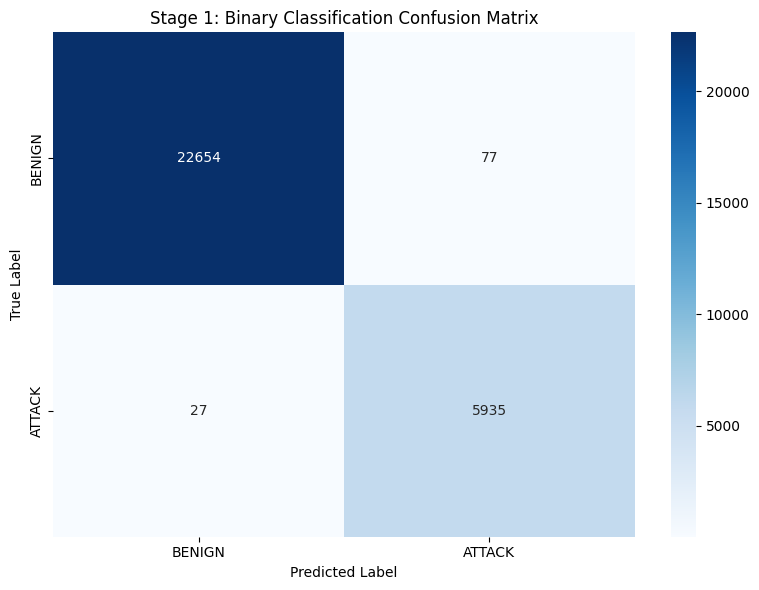


Stage 1 ROC-AUC: 0.9998


In [48]:
# Stage 1 confusion matrix
cm_s1 = confusion_matrix(y_test_binary, y_pred_s1_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_s1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['BENIGN', 'ATTACK'],
            yticklabels=['BENIGN', 'ATTACK'])
plt.title('Stage 1: Binary Classification Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'stage1_confusion_matrix.png'), dpi=150)
plt.show()

# ROC AUC
roc_auc = roc_auc_score(y_test_binary, y_proba_s1_test)
print(f"\nStage 1 ROC-AUC: {roc_auc:.4f}")

In [49]:
# Save Stage 1 model
with open(os.path.join(OUTPUT_DIR, 'model_stage1.pkl'), 'wb') as f:
    pickle.dump(model_s1, f)
print(f"Saved model_stage1.pkl")

Saved model_stage1.pkl


---
# Stage 2: Multi-class Classification (14 Attack Types)

In [50]:
# Prepare Stage 2 data (attacks only)
print("Stage 2: Multi-class Attack Classification")
print(f"Training samples: {len(X_train_attack_smote):,}")
print(f"Test samples: {len(X_test_attack):,}")
print(f"\nClass distribution (train after SMOTE):")
if hasattr(y_train_attack_smote, 'value_counts'):
    print(y_train_attack_smote.value_counts())
else:
    print(pd.Series(y_train_attack_smote).value_counts())

Stage 2: Multi-class Attack Classification
Training samples: 23,991
Test samples: 5,962

Class distribution (train after SMOTE):
Label
DoS Hulk                      9242
PortScan                      6357
DDoS                          5121
Bot                           1573
DoS GoldenEye                  411
FTP-Patator                    317
SSH-Patator                    235
DoS slowloris                  231
DoS Slowhttptest               219
Infiltration                   100
Web Attack � Brute Force        60
Heartbleed                      50
Web Attack � Sql Injection      50
Web Attack � XSS                25
Name: count, dtype: int64


In [51]:
# Encode Stage 2 labels
label_encoder_s2 = LabelEncoder()
y_train_s2_encoded = label_encoder_s2.fit_transform(y_train_attack_smote)
y_test_s2_encoded = label_encoder_s2.transform(y_test_attack)

print(f"Attack classes ({len(label_encoder_s2.classes_)}):")
for i, label in enumerate(label_encoder_s2.classes_):
    print(f"  {i:2}: {label}")

# Save Stage 2 label encoder
with open(os.path.join(OUTPUT_DIR, 'label_encoder_stage2.pkl'), 'wb') as f:
    pickle.dump(label_encoder_s2, f)

Attack classes (14):
   0: Bot
   1: DDoS
   2: DoS GoldenEye
   3: DoS Hulk
   4: DoS Slowhttptest
   5: DoS slowloris
   6: FTP-Patator
   7: Heartbleed
   8: Infiltration
   9: PortScan
  10: SSH-Patator
  11: Web Attack � Brute Force
  12: Web Attack � Sql Injection
  13: Web Attack � XSS


In [52]:
%%time
# Train Stage 2 XGBoost model
# Calculate class weights for imbalance
class_counts_s2 = pd.Series(y_train_s2_encoded).value_counts()
n_samples = len(y_train_s2_encoded)
n_classes = len(label_encoder_s2.classes_)
class_weights_s2 = {i: n_samples / (n_classes * count) for i, count in class_counts_s2.items()}

model_s2 = XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='mlogloss'
)

# Create sample weights
sample_weights = np.array([class_weights_s2[y] for y in y_train_s2_encoded])

model_s2.fit(X_train_attack_smote, y_train_s2_encoded, sample_weight=sample_weights)
print("Stage 2 model trained.")

Stage 2 model trained.
CPU times: total: 45 s
Wall time: 3.16 s


In [53]:
# Stage 2 predictions
y_pred_s2_train = model_s2.predict(X_train_attack_smote)
y_pred_s2_test = model_s2.predict(X_test_attack)

print("Stage 2 - Training Performance:")
print(classification_report(y_train_s2_encoded, y_pred_s2_train, 
                           target_names=label_encoder_s2.classes_))

print("\nStage 2 - Test Performance:")
print(classification_report(y_test_s2_encoded, y_pred_s2_test,
                           target_names=label_encoder_s2.classes_))

Stage 2 - Training Performance:
                            precision    recall  f1-score   support

                       Bot       1.00      1.00      1.00      1573
                      DDoS       1.00      1.00      1.00      5121
             DoS GoldenEye       1.00      1.00      1.00       411
                  DoS Hulk       1.00      1.00      1.00      9242
          DoS Slowhttptest       1.00      1.00      1.00       219
             DoS slowloris       0.99      1.00      1.00       231
               FTP-Patator       1.00      1.00      1.00       317
                Heartbleed       1.00      1.00      1.00        50
              Infiltration       1.00      1.00      1.00       100
                  PortScan       1.00      1.00      1.00      6357
               SSH-Patator       1.00      1.00      1.00       235
  Web Attack � Brute Force       0.98      1.00      0.99        60
Web Attack � Sql Injection       1.00      1.00      1.00        50
          Web A

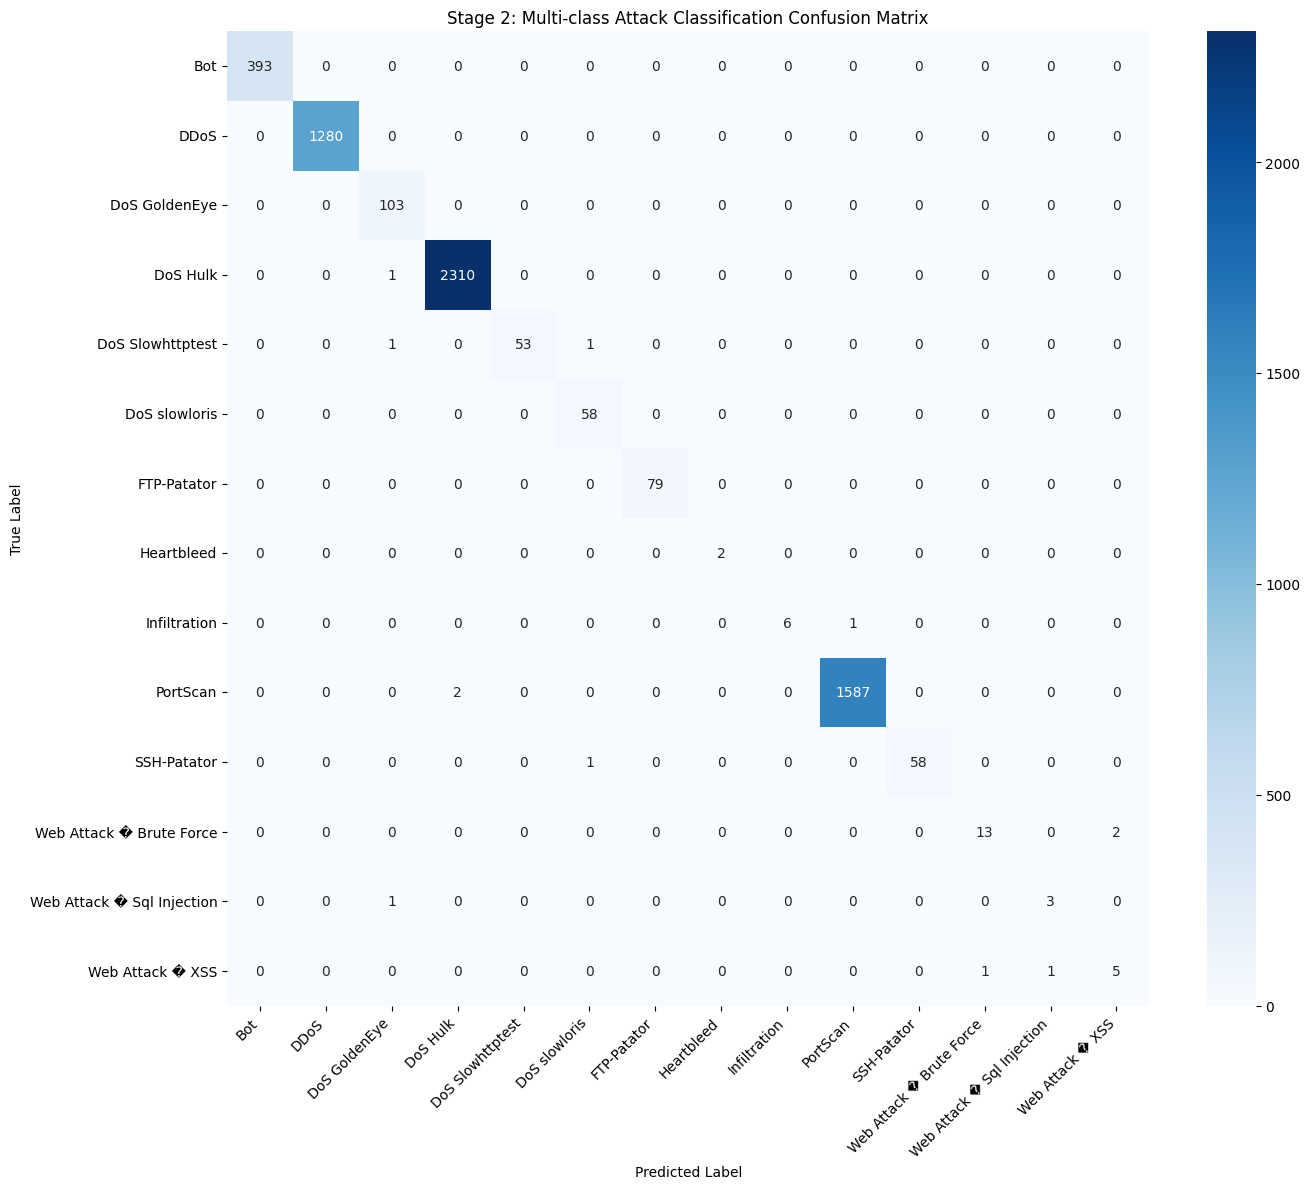

In [54]:
# Stage 2 confusion matrix
cm_s2 = confusion_matrix(y_test_s2_encoded, y_pred_s2_test)

plt.figure(figsize=(14, 12))
sns.heatmap(cm_s2, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder_s2.classes_,
            yticklabels=label_encoder_s2.classes_)
plt.title('Stage 2: Multi-class Attack Classification Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'stage2_confusion_matrix.png'), dpi=150)
plt.show()

In [55]:
# Save Stage 2 model
with open(os.path.join(OUTPUT_DIR, 'model_stage2.pkl'), 'wb') as f:
    pickle.dump(model_s2, f)
print(f"Saved model_stage2.pkl")

Saved model_stage2.pkl


---
# 2-Stage Pipeline Evaluation

In [56]:
def predict_2stage(X, model_s1, model_s2, label_encoder_s2):
    """
    2-Stage prediction pipeline:
    1. Stage 1: Classify as BENIGN (0) or ATTACK (1)
    2. Stage 2: If ATTACK, classify into specific attack type
    """
    # Stage 1: Binary classification
    pred_s1 = model_s1.predict(X)
    
    # Initialize final predictions
    final_predictions = np.array(['BENIGN'] * len(X), dtype=object)
    
    # Stage 2: Multi-class for attacks
    attack_mask = pred_s1 == 1
    if attack_mask.sum() > 0:
        X_attacks = X[attack_mask] if hasattr(X, '__getitem__') else X.iloc[attack_mask]
        pred_s2 = model_s2.predict(X_attacks)
        attack_labels = label_encoder_s2.inverse_transform(pred_s2)
        final_predictions[attack_mask] = attack_labels
    
    return final_predictions

print("2-Stage prediction function defined.")

2-Stage prediction function defined.


In [57]:
# Evaluate 2-stage pipeline on test set
y_pred_2stage = predict_2stage(X_test_scaled, model_s1, model_s2, label_encoder_s2)

# Get true labels
y_true = y_test_label.values

print("2-Stage Pipeline - Overall Test Performance:")
print(classification_report(y_true, y_pred_2stage))

2-Stage Pipeline - Overall Test Performance:
                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     22731
                       Bot       0.95      0.99      0.97       393
                      DDoS       1.00      1.00      1.00      1280
             DoS GoldenEye       0.94      0.98      0.96       103
                  DoS Hulk       0.99      1.00      1.00      2311
          DoS Slowhttptest       0.95      0.96      0.95        55
             DoS slowloris       0.97      1.00      0.98        58
               FTP-Patator       1.00      1.00      1.00        79
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       1.00      0.57      0.73         7
                  PortScan       0.99      1.00      1.00      1589
               SSH-Patator       1.00      0.98      0.99        59
  Web Attack � Brute Force       0.15      0.20      0.17        15
We

In [58]:
# Overall accuracy
overall_accuracy = accuracy_score(y_true, y_pred_2stage)
print(f"\n2-Stage Pipeline Overall Accuracy: {overall_accuracy:.4f}")


2-Stage Pipeline Overall Accuracy: 0.9961


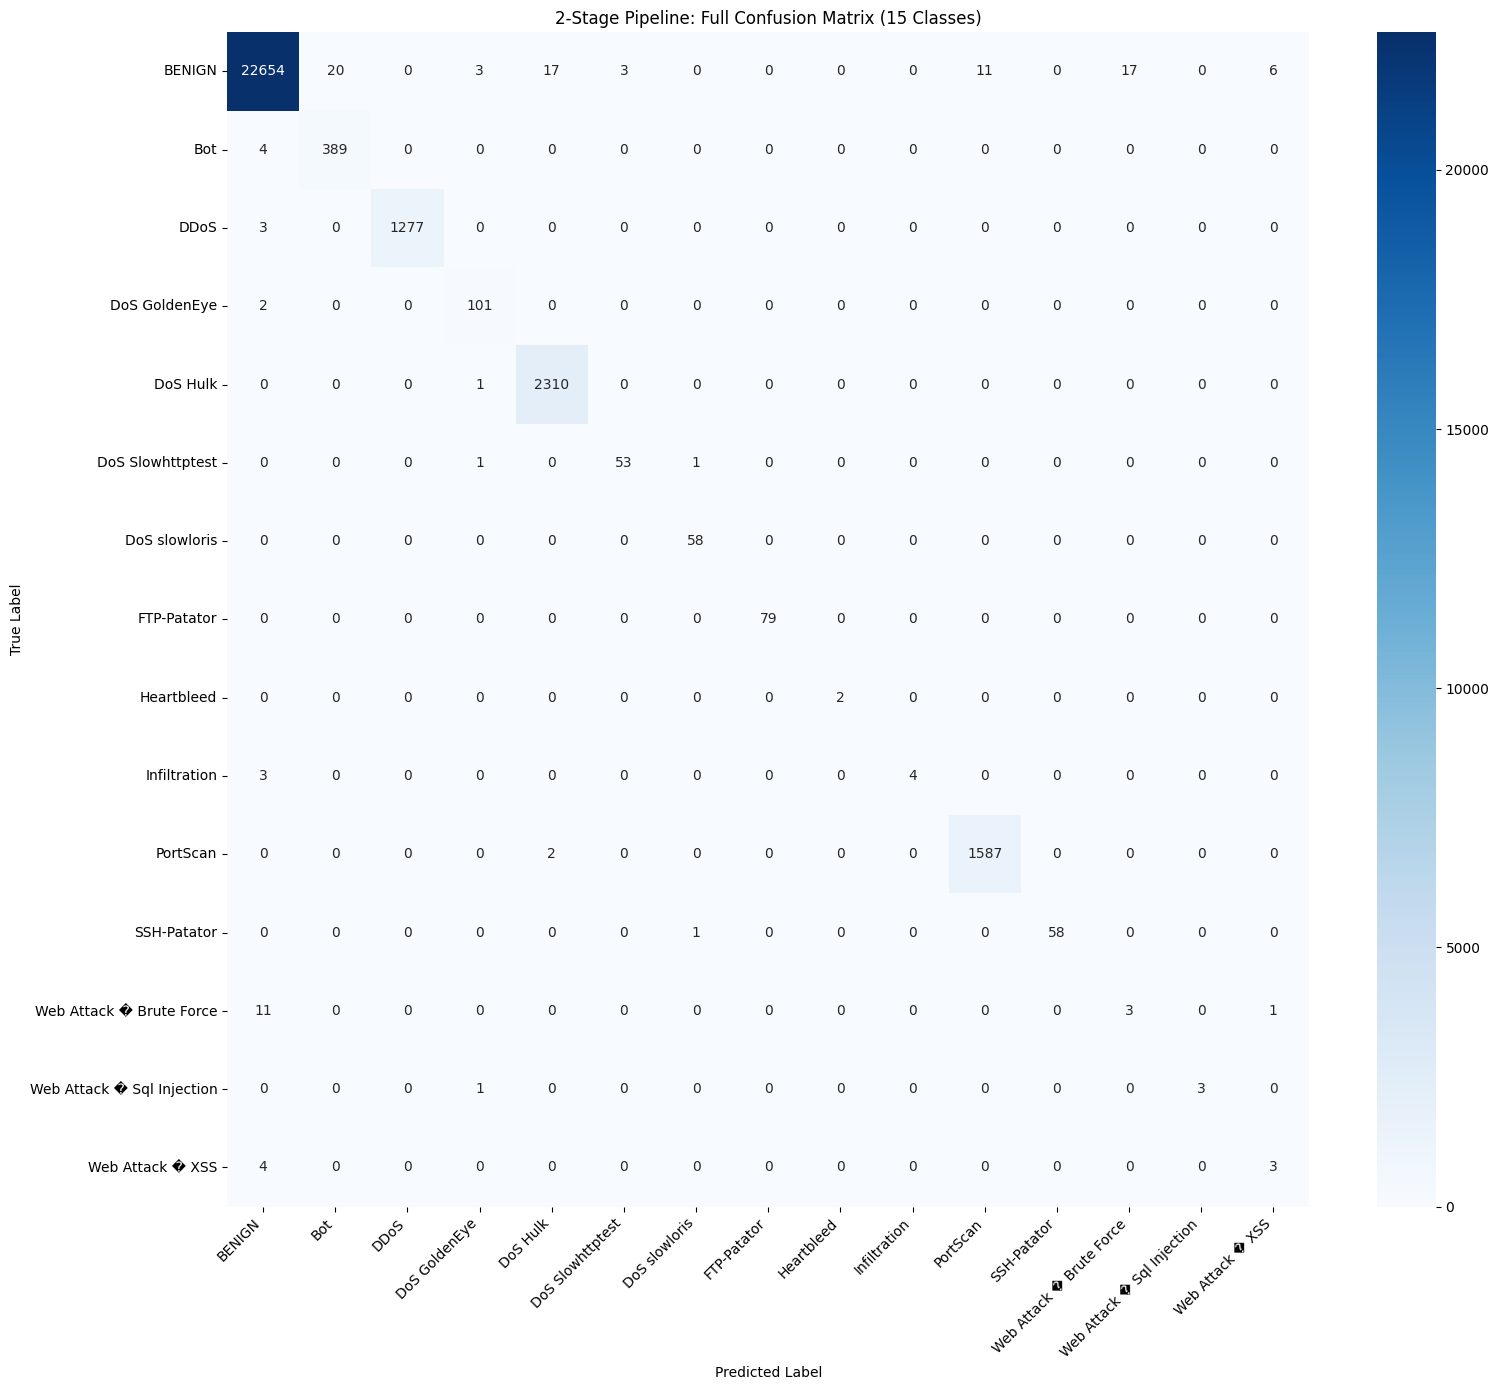

In [59]:
# 2-Stage confusion matrix (full)
all_labels = np.unique(np.concatenate([y_true, y_pred_2stage]))
cm_2stage = confusion_matrix(y_true, y_pred_2stage, labels=all_labels)

plt.figure(figsize=(16, 14))
sns.heatmap(cm_2stage, annot=True, fmt='d', cmap='Blues',
            xticklabels=all_labels,
            yticklabels=all_labels)
plt.title('2-Stage Pipeline: Full Confusion Matrix (15 Classes)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '2stage_confusion_matrix.png'), dpi=150)
plt.show()

---
# Feature Importance Analysis

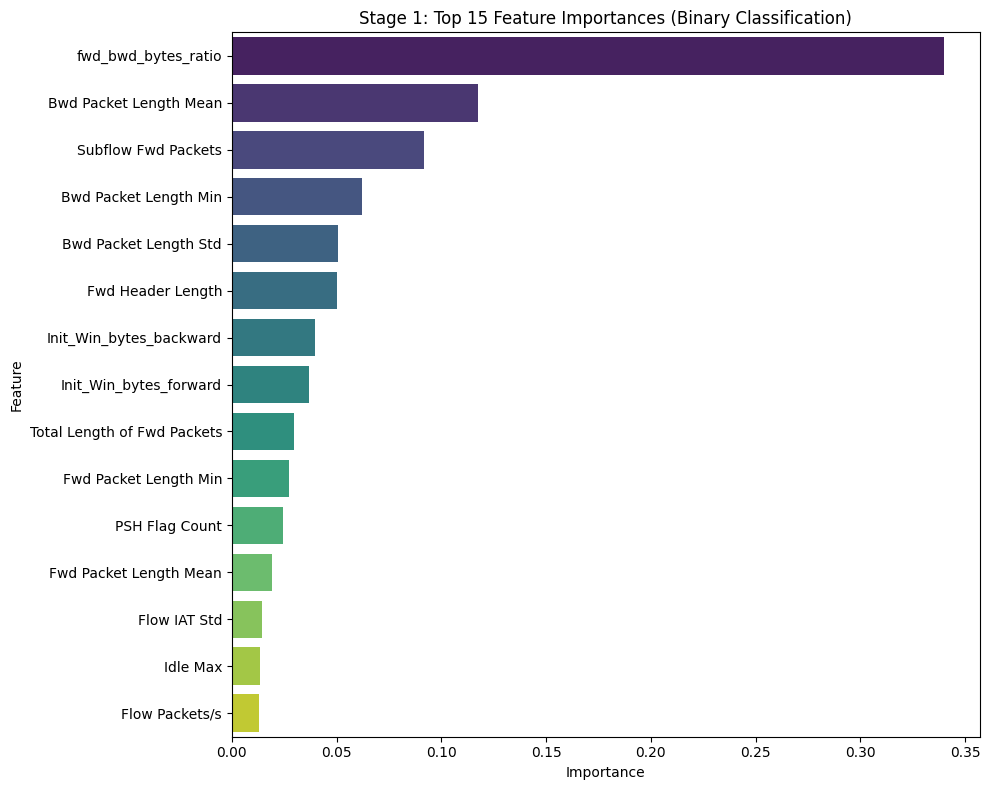

Stage 1 Top 10 Features:
                    feature  importance
        fwd_bwd_bytes_ratio    0.340150
     Bwd Packet Length Mean    0.117363
        Subflow Fwd Packets    0.091688
      Bwd Packet Length Min    0.062047
      Bwd Packet Length Std    0.050540
          Fwd Header Length    0.050058
    Init_Win_bytes_backward    0.039684
     Init_Win_bytes_forward    0.036651
Total Length of Fwd Packets    0.029615
      Fwd Packet Length Min    0.027224


In [60]:
# Stage 1 feature importance
importance_s1 = pd.DataFrame({
    'feature': feature_cols,
    'importance': model_s1.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_s1.head(15), x='importance', y='feature', palette='viridis')
plt.title('Stage 1: Top 15 Feature Importances (Binary Classification)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'stage1_feature_importance.png'), dpi=150)
plt.show()

print("Stage 1 Top 10 Features:")
print(importance_s1.head(10).to_string(index=False))

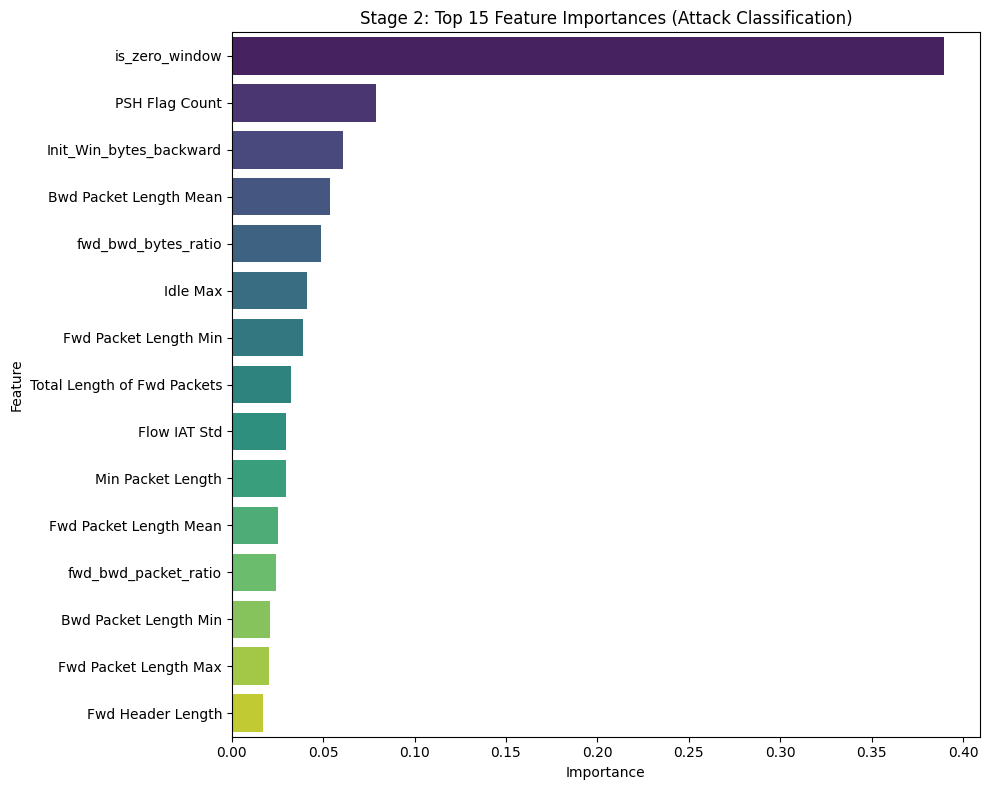

Stage 2 Top 10 Features:
                    feature  importance
             is_zero_window    0.389835
             PSH Flag Count    0.078987
    Init_Win_bytes_backward    0.060829
     Bwd Packet Length Mean    0.053543
        fwd_bwd_bytes_ratio    0.048657
                   Idle Max    0.041295
      Fwd Packet Length Min    0.039225
Total Length of Fwd Packets    0.032631
               Flow IAT Std    0.029916
          Min Packet Length    0.029684


In [61]:
# Stage 2 feature importance
importance_s2 = pd.DataFrame({
    'feature': feature_cols,
    'importance': model_s2.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_s2.head(15), x='importance', y='feature', palette='viridis')
plt.title('Stage 2: Top 15 Feature Importances (Attack Classification)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'stage2_feature_importance.png'), dpi=150)
plt.show()

print("Stage 2 Top 10 Features:")
print(importance_s2.head(10).to_string(index=False))

---
# Summary

In [62]:
print("="*70)
print("PREPROCESSING & 2-STAGE MODEL COMPLETE")
print("="*70)

print(f"\n📊 DATASET SUMMARY:")
print(f"   Original samples: ~2.8M")
print(f"   After sampling: {len(df):,}")
print(f"   Train/Test split: {len(X_train):,} / {len(X_test):,}")
print(f"   Features: {len(feature_cols)}")

print(f"\n🎯 MODEL PERFORMANCE:")
print(f"   Stage 1 (Binary):      {accuracy_score(y_test_binary, y_pred_s1_test):.4f} accuracy")
print(f"   Stage 1 ROC-AUC:       {roc_auc:.4f}")
print(f"   Stage 2 (14 attacks):  {accuracy_score(y_test_s2_encoded, y_pred_s2_test):.4f} accuracy")
print(f"   2-Stage Pipeline:      {overall_accuracy:.4f} accuracy")

print(f"\n📁 SAVED ARTIFACTS:")
for f in sorted(os.listdir(OUTPUT_DIR)):
    print(f"   {f}")

print(f"\n✅ Ready for deployment!")

PREPROCESSING & 2-STAGE MODEL COMPLETE

📊 DATASET SUMMARY:
   Original samples: ~2.8M
   After sampling: 143,462
   Train/Test split: 114,769 / 28,693
   Features: 27

🎯 MODEL PERFORMANCE:
   Stage 1 (Binary):      0.9964 accuracy
   Stage 1 ROC-AUC:       0.9998
   Stage 2 (14 attacks):  0.9980 accuracy
   2-Stage Pipeline:      0.9961 accuracy

📁 SAVED ARTIFACTS:
   2stage_confusion_matrix.png
   feature_config.json
   label_encoder.pkl
   label_encoder_stage2.pkl
   model_stage1.pkl
   model_stage2.pkl
   preprocessing_config.json
   scaler.pkl
   stage1_confusion_matrix.png
   stage1_feature_importance.png
   stage2_confusion_matrix.png
   stage2_feature_importance.png
   test_stage1.csv
   test_stage2.csv
   train_stage1.csv
   train_stage2.csv

✅ Ready for deployment!
